In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from scipy.stats import randint, uniform
from gpboost import GPBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [30]:
df=pd.read_csv("mergedfile_patient_age_yearsall.txt", sep="\t")

In [31]:
mutation_cols = df.columns[1:12941]     
meta_cols_before = df.columns[:1]     
meta_cols_after = df.columns[12941:]    
new_cols = pd.DataFrame(index=df.index)
for col in mutation_cols:
    parts = col.split(',')
    base = parts[0]      
    alleles = parts[1:]  
    col_numeric = pd.to_numeric(df[col], errors='coerce')
    new_cols[base] = col_numeric.apply(lambda x: 1 if x > 0 else 0)
    for i, allele in enumerate(alleles, start=1):
        allele_col = base[:-1] + allele  # e.g., A1C (remove '*')
        new_cols[allele_col] = col_numeric.apply(lambda x: 1 if x == i else 0)
final_df = pd.concat([df[meta_cols_before], new_cols, df[meta_cols_after]], axis=1)

In [32]:
cols_with_star = [col for col in final_df.columns if '*' in col]
print(cols_with_star[:10]) 

['A1*', 'T2*', 'T3*', 'A4*', 'A5*', 'A6*', 'G7*', 'G8*', 'T9*', 'T10*']


In [33]:
final_df = final_df.drop(columns=cols_with_star)

In [34]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29875G,A29876G,A29877T,A29891G,A29892G,Location,Gender,Patient age,Additional host information,Lineage
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Europe / Turkey,Male,87.00,Severe,B
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Slovakia / Okres Presov,Female,91.00,Severe,B.1.1.529
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,South America / Brazil / Rio de Janeiro / Rio ...,Male,35.00,Severe,BA.1
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Asia / China / Fujian,Male,70.00,Severe,EG.5.1.1
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Asia / China / Fujian,Female,19.00,Severe,HK.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Spain / Catalunya / Mataro,Male,94.00,Severe,JN.1.4 (consensus call)
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Spain / Catalunya / Mataro,Female,81.00,Severe,KP.3.1.1 (consensus call)
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,North America / USA / New York / Westchester C...,Male,0.42,Severe,JN.1.4 (consensus call)
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,North America / Mexico / Guanajuato,Female,26.00,Severe,XBB.1.16.15


In [35]:
final_df.drop(columns=['Location', 'Lineage', 'Additional host information'], inplace=True)

In [36]:
metadatatwo = pd.read_csv("metadata2.txt", sep="\t")
finalfile = pd.merge(final_df, metadatatwo, on="strain")

In [37]:
finalfile

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29877T,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,Male,87.00,19A,B,Europe,Turkey,Severe
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,19.00,23H,HK.3,Asia,China,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe


In [38]:
finalfile['Gender'] = finalfile['Gender'].replace('Hombre', 'Male') 
finalfile['Gender'] = finalfile['Gender'].replace('Mujer', 'Female')
finalfile['Gender'] = finalfile['Gender'].replace('Malex', 'Female')
finalfile['Gender'] = finalfile['Gender'].replace('Famale', 'Female')

In [39]:
finalfile['Gender'].value_counts()

Gender
Female    7856
Male      6121
Name: count, dtype: int64

In [40]:
final_df=finalfile

In [41]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29877T,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,Male,87.00,19A,B,Europe,Turkey,Severe
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,19.00,23H,HK.3,Asia,China,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe


In [42]:
final_df['category'] = pd.get_dummies(final_df['category'])['Severe'].astype(int)
print(final_df['category'].head())

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64


In [43]:
final_df['Gender'] = pd.get_dummies(final_df['Gender'])['Female'].astype(int)
print(final_df['Gender'].head())

0    0
1    1
2    0
3    0
4    1
Name: Gender, dtype: int64


In [44]:
clade_dummies = pd.get_dummies(final_df ['clade'], prefix='clade').astype(int)
final_df  = pd.concat([final_df , clade_dummies], axis=1)
final_df  = final_df .drop(['clade', 'clade_24C'], axis = 1)

In [45]:
Nextclade_dummies = pd.get_dummies(final_df ['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
final_df  = pd.concat([final_df , Nextclade_dummies], axis=1)
final_df = final_df.drop(['Nextclade_pango', 'Nextclade_pango_XEN'], axis = 1)

In [46]:
region_dummies = pd.get_dummies(final_df['region'], prefix='region').astype(int)
final_df = pd.concat([final_df, region_dummies], axis=1)
final_df = final_df.drop(['region', 'region_Africa'], axis = 1)

In [47]:
first_col = final_df.loc[:, ["strain","country"]]
first_col

,strain,country
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,Turkey
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,Slovakia
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,Brazil
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,China
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,China
...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,Spain
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,Spain
13974,hCoV-19/USA/NY-WMC-6178/2024,USA
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,Mexico


In [48]:
rest = final_df.drop(columns=['strain', 'country'])
rest

,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,A4T,...,Nextclade_pango_XEW,Nextclade_pango_XFB,Nextclade_pango_XFC,Nextclade_pango_XFG,Nextclade_pango_XFJ,Nextclade_pango_XFL,region_Asia,region_Europe,region_North America,region_South America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
13973,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
13974,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
13975,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [49]:
filtered_rest = rest.loc[:, (rest.sum(axis=0) >= 10)]
final_df_filtered = pd.concat([first_col, filtered_rest], axis=1)
print("Filtered shape:", final_df_filtered.shape)

Filtered shape: (13977, 9612)


In [50]:
country_dummies = pd.get_dummies(final_df_filtered['country'], prefix='country').astype(int)
final_df_filtered = pd.concat([final_df_filtered , country_dummies], axis=1)
final_df_filtered = final_df_filtered.drop(['country_Senegal'], axis = 1)

In [51]:
final_df_filtered

,strain,country,T2G,T3C,A4T,A4C,A5G,A6R,G7T,G8T,...,country_Russia,country_Saint Martin,country_Slovakia,country_Spain,country_Taiwan,country_Thailand,country_Turkey,country_USA,country_Uganda,country_Vietnam
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,Turkey,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,Slovakia,1,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,Brazil,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,China,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,China,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,Spain,1,1,1,0,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,Spain,1,1,1,0,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
13974,hCoV-19/USA/NY-WMC-6178/2024,USA,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,Mexico,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X = final_df_filtered.drop(columns=['category', 'strain','country'])

In [53]:
y = final_df_filtered['category']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64

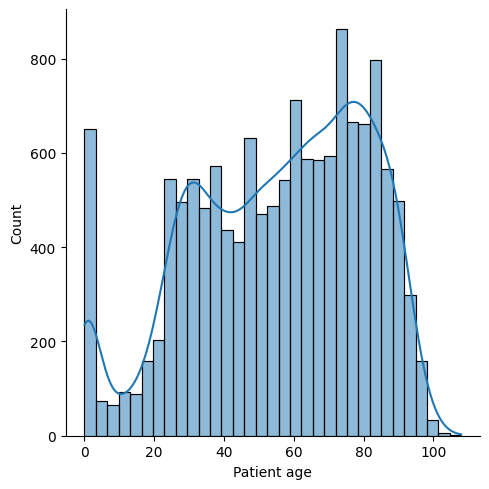

In [54]:
sns.displot(X["Patient age"], kde=True)
plt.show()

In [55]:
groups = final_df_filtered['country']


=== Fold 1: Test country = Argentina ===
Train size: 13920, Test size: 57
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0056
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


Confusion Matrix:
 [[57]]


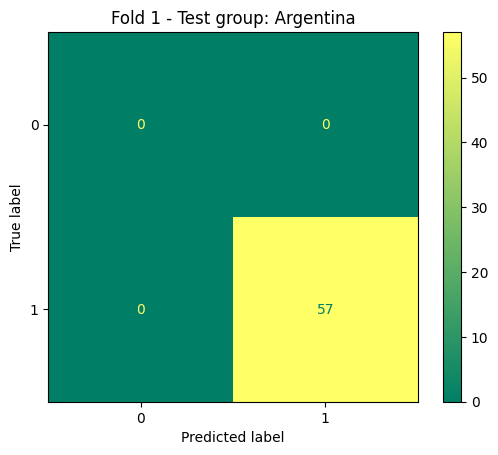


=== Fold 2: Test country = Austria ===
Train size: 13976, Test size: 1
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0219
Test ECE: 0.1481
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.010897516665982286), 'max_depth': 20, 'n_estimators': 587, 'num_leaves': 45}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


Confusion Matrix:
 [[1]]


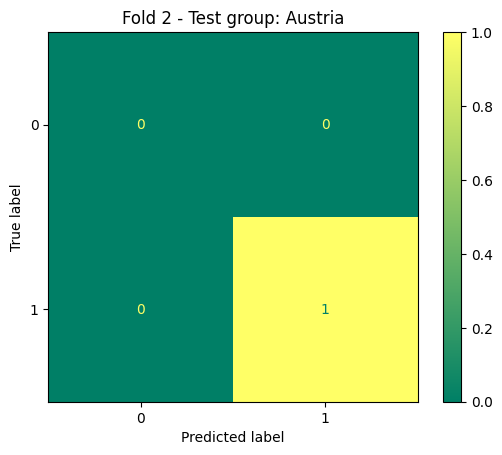


=== Fold 3: Test country = Belgium ===
Train size: 13972, Test size: 5
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0001
Test ECE: 0.0109
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.010897516665982286), 'max_depth': 20, 'n_estimators': 587, 'num_leaves': 45}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


Confusion Matrix:
 [[5]]


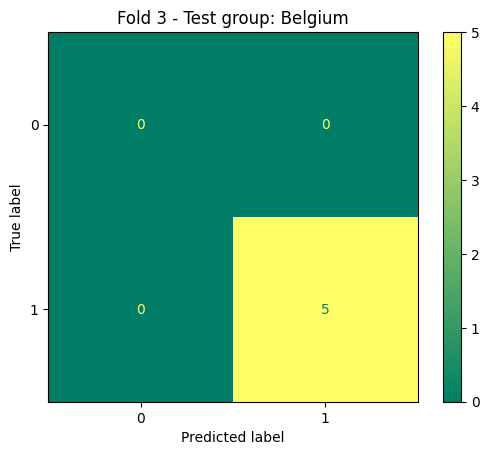


=== Fold 4: Test country = Botswana ===
Train size: 13975, Test size: 2
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0032
Test ECE: 0.0435
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


Confusion Matrix:
 [[2]]


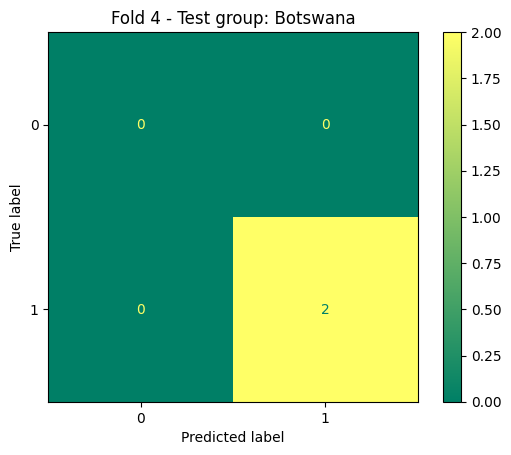


=== Fold 5: Test country = Brazil ===
Train size: 13059, Test size: 918
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0406
Test ECE: 0.0858
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.08816631606251052), 'max_depth': 15, 'n_estimators': 1295, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97       918

    accuracy                           0.94       918
   macro avg       0.50      0.47      0.49       918
weighted avg       1.00      0.94      0.97       918


Confusion Matrix:
 [[  0   0]
 [ 53 865]]


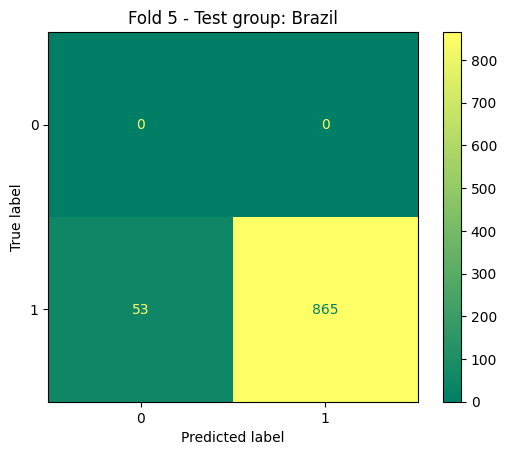


=== Fold 6: Test country = Bulgaria ===
Train size: 13976, Test size: 1
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0009
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.010897516665982286), 'max_depth': 20, 'n_estimators': 587, 'num_leaves': 45}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


Confusion Matrix:
 [[1]]


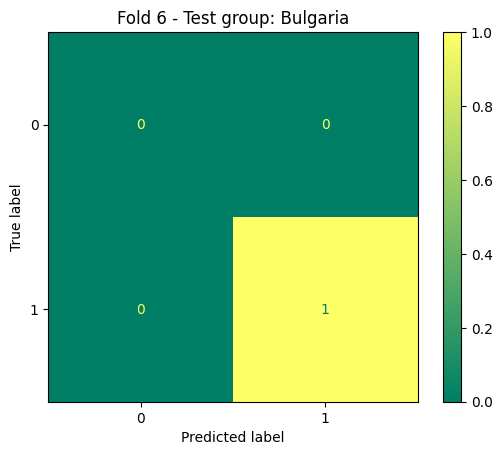


=== Fold 7: Test country = China ===
Train size: 13568, Test size: 409
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0210
Test ECE: 0.1204
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       409

    accuracy                           1.00       409
   macro avg       1.00      1.00      1.00       409
weighted avg       1.00      1.00      1.00       409


Confusion Matrix:
 [[409]]


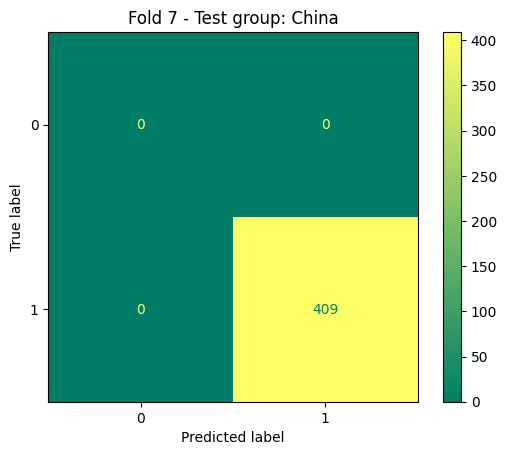


=== Fold 8: Test country = Colombia ===
Train size: 13961, Test size: 16
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0002
Test ECE: 0.0129
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        16

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16


Confusion Matrix:
 [[16]]


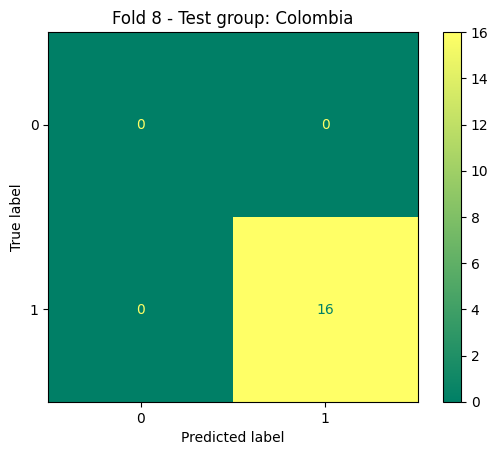


=== Fold 9: Test country = France ===
Train size: 9158, Test size: 4819
Test ROC AUC (positive class = 1): 0.5168
Test AUPRC: 0.3326
Test Brier Score: 0.6161
Test ECE: 0.6324
Test Precision (macro): 0.5034
Test Recall (macro): 0.5002
Test F1-score (macro): 0.2393

Best Parameters: {'learning_rate': np.float64(0.06019209790229743), 'max_depth': 24, 'n_estimators': 955, 'num_leaves': 23}

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.01      0.02      3381
           1       0.30      0.99      0.46      1438

    accuracy                           0.30      4819
   macro avg       0.50      0.50      0.24      4819
weighted avg       0.59      0.30      0.15      4819


Confusion Matrix:
 [[  34 3347]
 [  14 1424]]


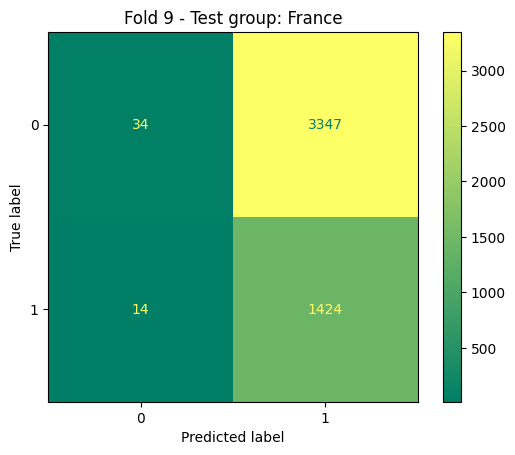


=== Fold 10: Test country = Germany ===
Train size: 13951, Test size: 26
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0006
Test ECE: 0.0207
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        26

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26


Confusion Matrix:
 [[26]]


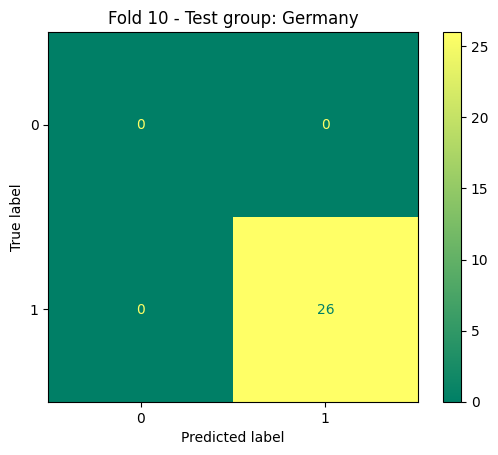


=== Fold 11: Test country = Guadeloupe ===
Train size: 13930, Test size: 47
Test ROC AUC (positive class = 1): 0.4208
Test AUPRC: 0.2542
Test Brier Score: 0.5713
Test ECE: 0.5893
Test Precision (macro): 0.6444
Test Recall (macro): 0.5294
Test F1-score (macro): 0.2797

Best Parameters: {'learning_rate': np.float64(0.04328367107399938), 'max_depth': 22, 'n_estimators': 1782, 'num_leaves': 48}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.06      0.11        34
           1       0.29      1.00      0.45        13

    accuracy                           0.32        47
   macro avg       0.64      0.53      0.28        47
weighted avg       0.80      0.32      0.20        47


Confusion Matrix:
 [[ 2 32]
 [ 0 13]]


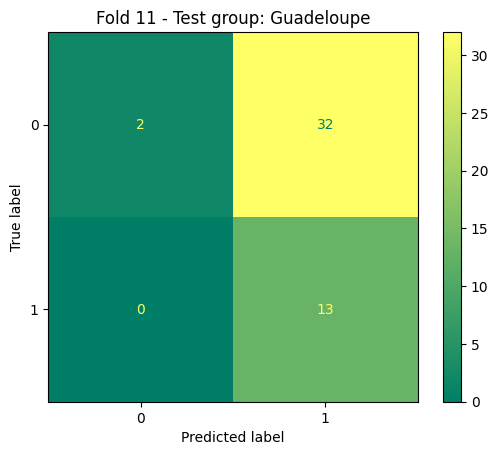


=== Fold 12: Test country = Guatemala ===
Train size: 13975, Test size: 2
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0000
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06083732054850391), 'max_depth': 24, 'n_estimators': 1694, 'num_leaves': 38}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


Confusion Matrix:
 [[2]]


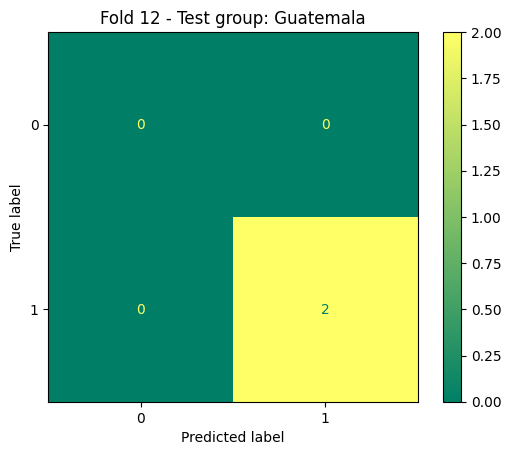


=== Fold 13: Test country = Guinea ===
Train size: 13976, Test size: 1
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0001
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06157343657751557), 'max_depth': 37, 'n_estimators': 1199, 'num_leaves': 25}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


Confusion Matrix:
 [[1]]


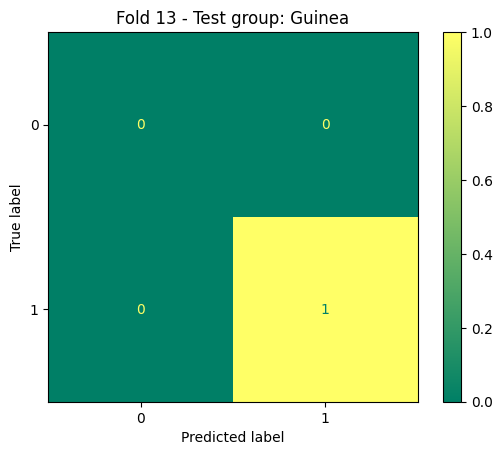


=== Fold 14: Test country = India ===
Train size: 13974, Test size: 3
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0002
Test ECE: 0.0146
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.010897516665982286), 'max_depth': 20, 'n_estimators': 587, 'num_leaves': 45}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3


Confusion Matrix:
 [[3]]


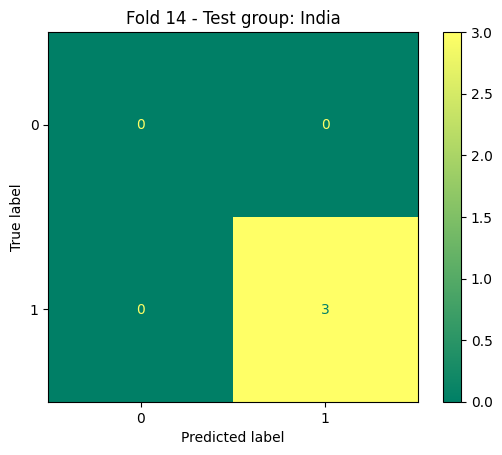


=== Fold 15: Test country = Indonesia ===
Train size: 13944, Test size: 33
Test ROC AUC (positive class = 1): 1.0000
Test AUPRC: 1.0000
Test Brier Score: 0.6093
Test ECE: 0.7282
Test Precision (macro): 0.0606
Test Recall (macro): 0.5000
Test F1-score (macro): 0.1081

Best Parameters: {'learning_rate': np.float64(0.010897516665982286), 'max_depth': 20, 'n_estimators': 587, 'num_leaves': 45}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.12      1.00      0.22         4

    accuracy                           0.12        33
   macro avg       0.06      0.50      0.11        33
weighted avg       0.01      0.12      0.03        33


Confusion Matrix:
 [[ 0 29]
 [ 0  4]]


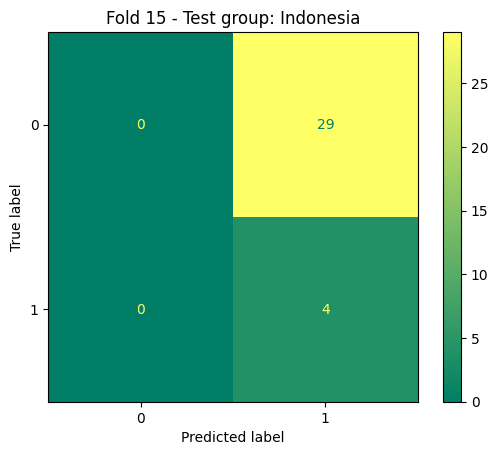


=== Fold 16: Test country = Iran ===
Train size: 13974, Test size: 3
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0001
Test ECE: 0.0092
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3


Confusion Matrix:
 [[3]]


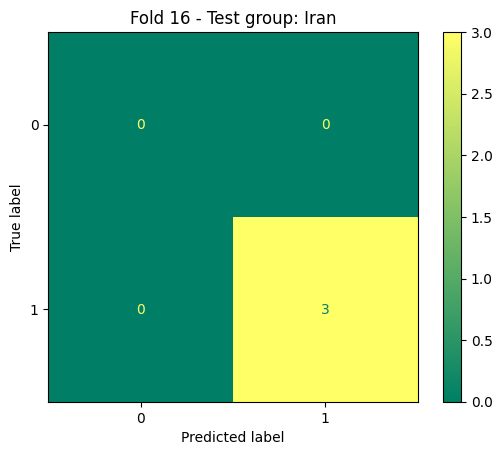


=== Fold 17: Test country = Ireland ===
Train size: 13976, Test size: 1
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0002
Test ECE: 0.0147
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.004404463590406622), 'max_depth': 23, 'n_estimators': 1604, 'num_leaves': 45}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


Confusion Matrix:
 [[1]]


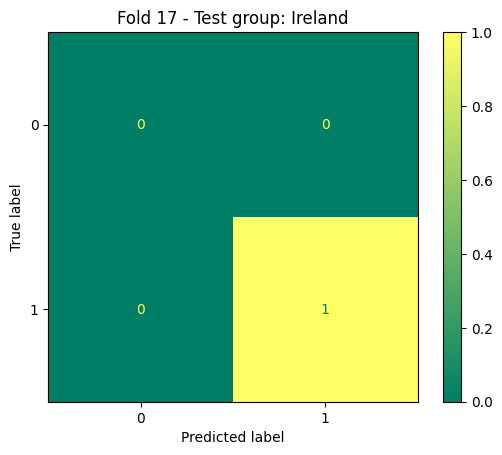


=== Fold 18: Test country = Italy ===
Train size: 13931, Test size: 46
Test ROC AUC (positive class = 1): 0.6244
Test AUPRC: 0.9353
Test Brier Score: 0.1120
Test ECE: 0.1167
Test Precision (macro): 0.4457
Test Recall (macro): 0.5000
Test F1-score (macro): 0.4713

Best Parameters: {'learning_rate': np.float64(0.0915810078788343), 'max_depth': 18, 'n_estimators': 1279, 'num_leaves': 43}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.89      1.00      0.94        41

    accuracy                           0.89        46
   macro avg       0.45      0.50      0.47        46
weighted avg       0.79      0.89      0.84        46


Confusion Matrix:
 [[ 0  5]
 [ 0 41]]


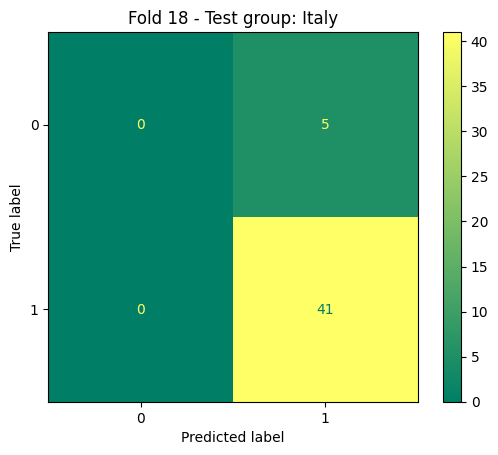


=== Fold 19: Test country = Kenya ===
Train size: 13973, Test size: 4
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0002
Test ECE: 0.0101
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


Confusion Matrix:
 [[4]]


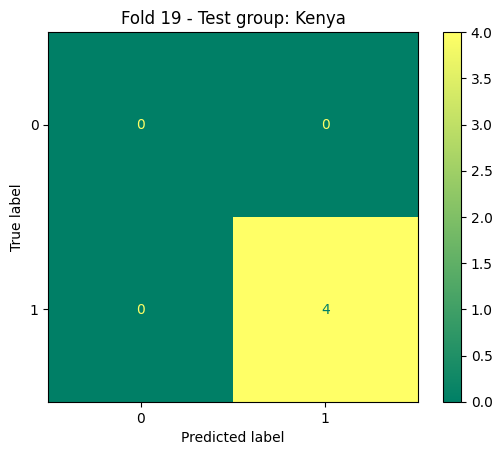


=== Fold 20: Test country = Kosovo ===
Train size: 13953, Test size: 24
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0044
Test ECE: 0.0248
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.08816631606251052), 'max_depth': 15, 'n_estimators': 1295, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        24

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24


Confusion Matrix:
 [[24]]


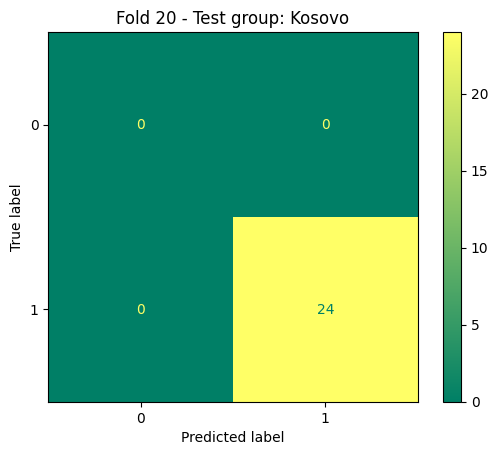


=== Fold 21: Test country = Lebanon ===
Train size: 13965, Test size: 12
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0006
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.08816631606251052), 'max_depth': 15, 'n_estimators': 1295, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


Confusion Matrix:
 [[12]]


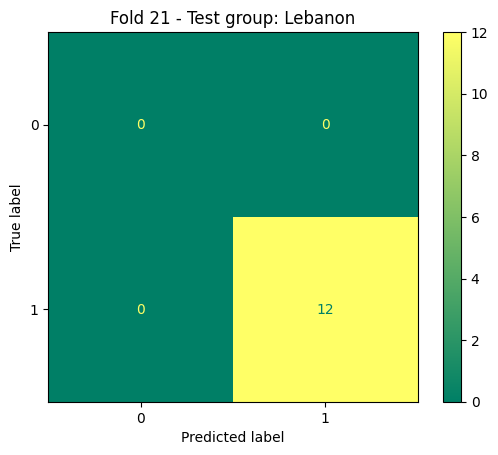


=== Fold 22: Test country = Malaysia ===
Train size: 13965, Test size: 12
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0018
Test ECE: 0.0310
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.09857939495694948), 'max_depth': 41, 'n_estimators': 746, 'num_leaves': 13}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


Confusion Matrix:
 [[12]]


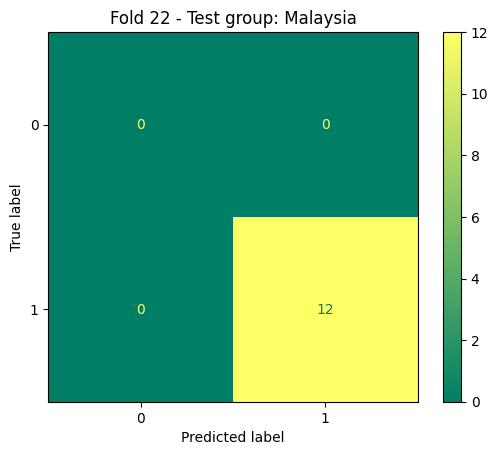


=== Fold 23: Test country = Mexico ===
Train size: 10998, Test size: 2979
Test ROC AUC (positive class = 1): 0.5045
Test AUPRC: 0.6919
Test Brier Score: 0.2979
Test ECE: 0.2709
Test Precision (macro): 0.3638
Test Recall (macro): 0.4931
Test F1-score (macro): 0.3912

Best Parameters: {'learning_rate': np.float64(0.004404463590406622), 'max_depth': 23, 'n_estimators': 1604, 'num_leaves': 45}

Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.00      0.01      1057
           1       0.64      0.98      0.78      1922

    accuracy                           0.64      2979
   macro avg       0.36      0.49      0.39      2979
weighted avg       0.44      0.64      0.50      2979


Confusion Matrix:
 [[   3 1054]
 [  32 1890]]


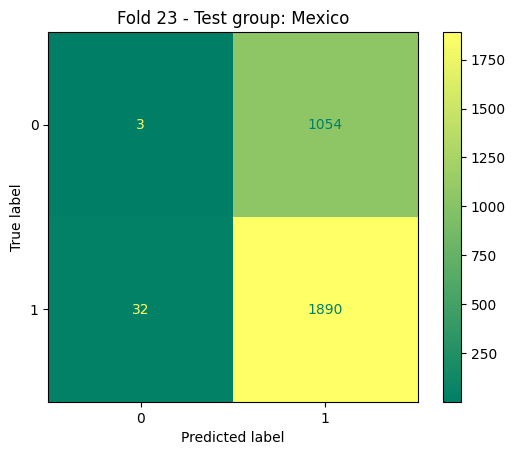


=== Fold 24: Test country = Moldova ===
Train size: 13920, Test size: 57
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0047
Test ECE: 0.0667
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


Confusion Matrix:
 [[57]]


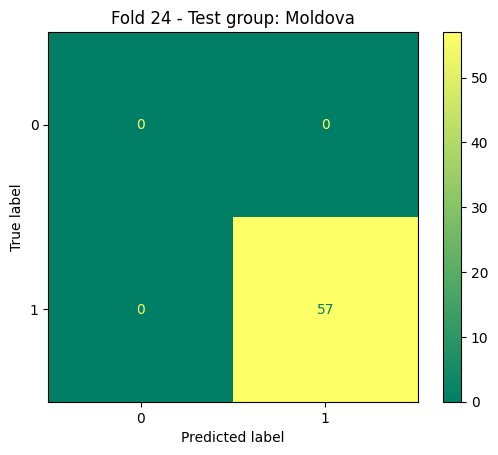


=== Fold 25: Test country = Montenegro ===
Train size: 13958, Test size: 19
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0004
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.08816631606251052), 'max_depth': 15, 'n_estimators': 1295, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        19

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19


Confusion Matrix:
 [[19]]


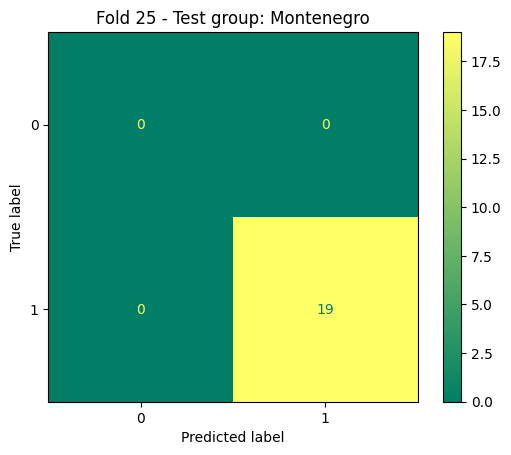


=== Fold 26: Test country = Pakistan ===
Train size: 13895, Test size: 82
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0038
Test ECE: 0.0492
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.004404463590406622), 'max_depth': 23, 'n_estimators': 1604, 'num_leaves': 45}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        82

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82


Confusion Matrix:
 [[82]]


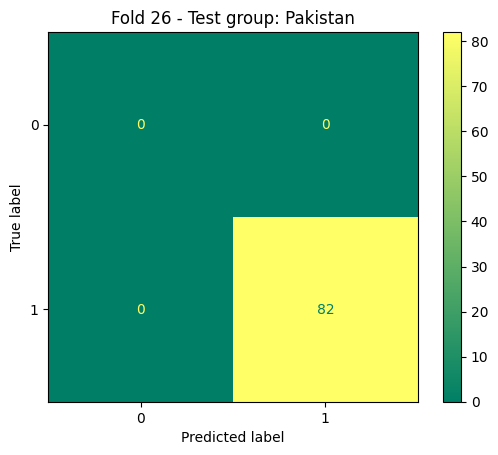


=== Fold 27: Test country = Paraguay ===
Train size: 13955, Test size: 22
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0001
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.08816631606251052), 'max_depth': 15, 'n_estimators': 1295, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        22

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


Confusion Matrix:
 [[22]]


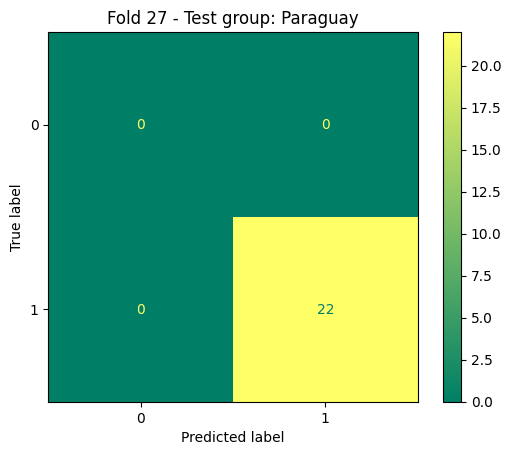


=== Fold 28: Test country = Philippines ===
Train size: 13973, Test size: 4
Test ROC AUC (positive class = 1): 1.0000
Test AUPRC: 1.0000
Test Brier Score: 0.7092
Test ECE: 0.7289
Test Precision (macro): 0.1250
Test Recall (macro): 0.5000
Test F1-score (macro): 0.2000

Best Parameters: {'learning_rate': np.float64(0.06099003750332013), 'max_depth': 48, 'n_estimators': 1517, 'num_leaves': 50}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      1.00      0.40         1

    accuracy                           0.25         4
   macro avg       0.12      0.50      0.20         4
weighted avg       0.06      0.25      0.10         4


Confusion Matrix:
 [[0 3]
 [0 1]]


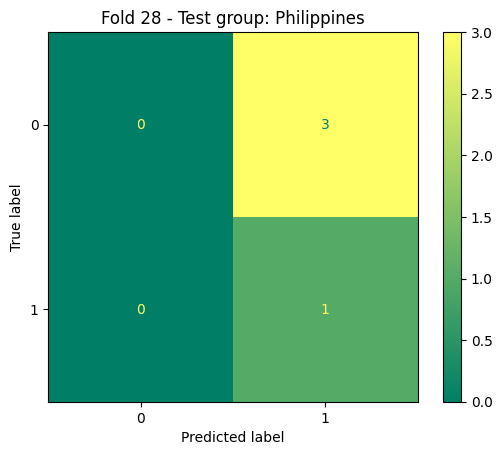


=== Fold 29: Test country = Poland ===
Train size: 13959, Test size: 18
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0024
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06083732054850391), 'max_depth': 24, 'n_estimators': 1694, 'num_leaves': 38}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        18

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18


Confusion Matrix:
 [[18]]


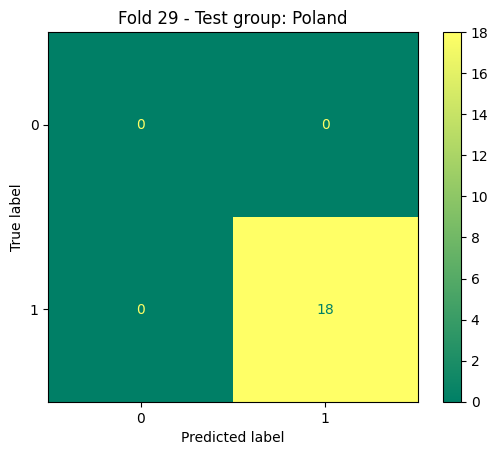


=== Fold 30: Test country = Qatar ===
Train size: 13792, Test size: 185
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0000
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06099003750332013), 'max_depth': 48, 'n_estimators': 1517, 'num_leaves': 50}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       185

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185


Confusion Matrix:
 [[185]]


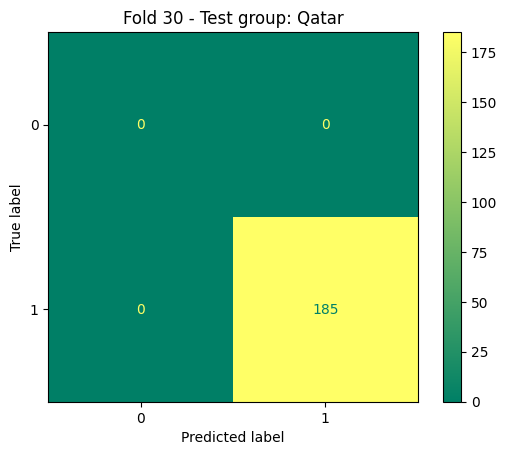


=== Fold 31: Test country = Romania ===
Train size: 13968, Test size: 9
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0039
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.0915810078788343), 'max_depth': 18, 'n_estimators': 1279, 'num_leaves': 43}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9


Confusion Matrix:
 [[9]]


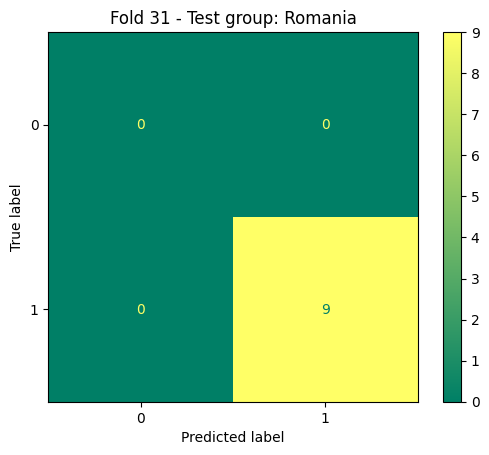


=== Fold 32: Test country = Russia ===
Train size: 13976, Test size: 1
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0001
Test ECE: 0.0099
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06955116725613676), 'max_depth': 33, 'n_estimators': 1897, 'num_leaves': 41}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


Confusion Matrix:
 [[1]]


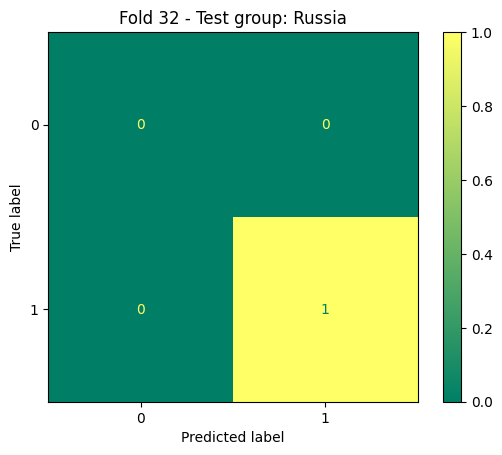


=== Fold 33: Test country = Saint Martin ===
Train size: 13976, Test size: 1
ROC AUC skipped (only one class in test set)
Test AUPRC: 0.0000
Test Brier Score: 0.8219
Test ECE: 0.9066
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.08816631606251052), 'max_depth': 15, 'n_estimators': 1295, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0


Confusion Matrix:
 [[0 1]
 [0 0]]


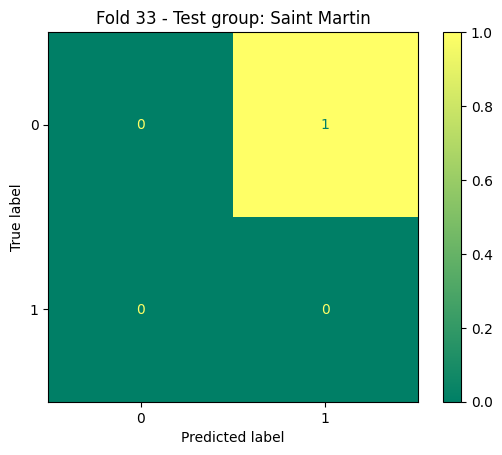


=== Fold 34: Test country = Senegal ===
Train size: 13943, Test size: 34
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0469
Test ECE: 0.1400
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.08816631606251052), 'max_depth': 15, 'n_estimators': 1295, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.97      0.99        34

    accuracy                           0.97        34
   macro avg       0.50      0.49      0.49        34
weighted avg       1.00      0.97      0.99        34


Confusion Matrix:
 [[ 0  0]
 [ 1 33]]


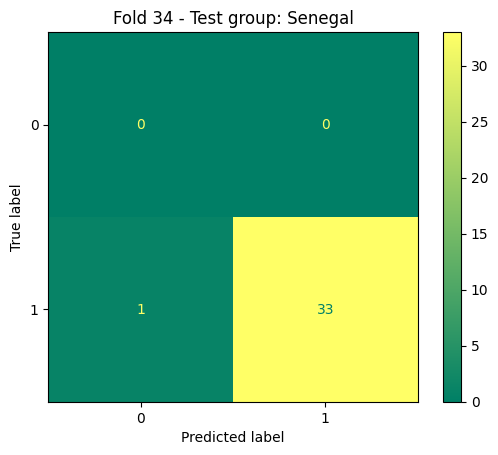


=== Fold 35: Test country = Slovakia ===
Train size: 13908, Test size: 69
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0047
Test ECE: 0.0223
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.061553662888339813), 'max_depth': 34, 'n_estimators': 2084, 'num_leaves': 36}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        69

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


Confusion Matrix:
 [[69]]


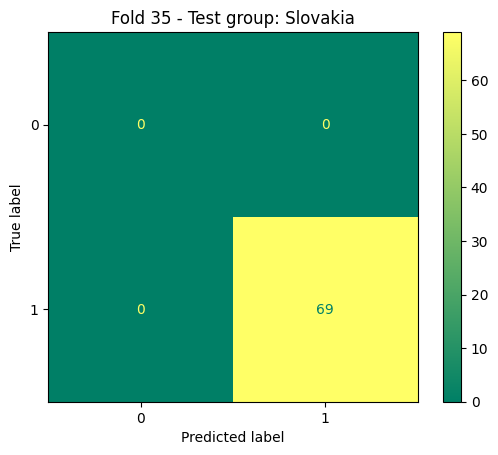


=== Fold 36: Test country = Spain ===
Train size: 10366, Test size: 3611
Test ROC AUC (positive class = 1): 0.7026
Test AUPRC: 0.8956
Test Brier Score: 0.2264
Test ECE: 0.2161
Test Precision (macro): 0.3781
Test Recall (macro): 0.4996
Test F1-score (macro): 0.4304

Best Parameters: {'learning_rate': np.float64(0.017300929461151235), 'max_depth': 36, 'n_estimators': 1148, 'num_leaves': 46}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       880
           1       0.76      1.00      0.86      2731

    accuracy                           0.76      3611
   macro avg       0.38      0.50      0.43      3611
weighted avg       0.57      0.76      0.65      3611


Confusion Matrix:
 [[   0  880]
 [   2 2729]]


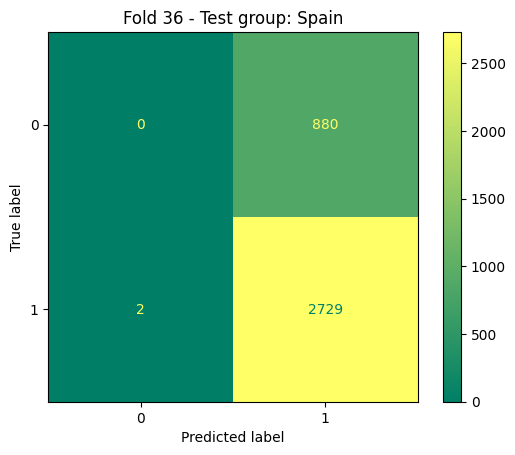


=== Fold 37: Test country = Taiwan ===
Train size: 13831, Test size: 146
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0070
Test ECE: 0.0721
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       146

    accuracy                           1.00       146
   macro avg       1.00      1.00      1.00       146
weighted avg       1.00      1.00      1.00       146


Confusion Matrix:
 [[146]]


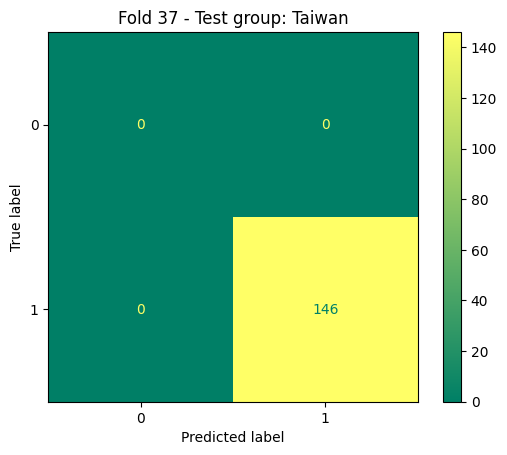


=== Fold 38: Test country = Thailand ===
Train size: 13940, Test size: 37
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0010
Test ECE: 0.0267
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        37

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37


Confusion Matrix:
 [[37]]


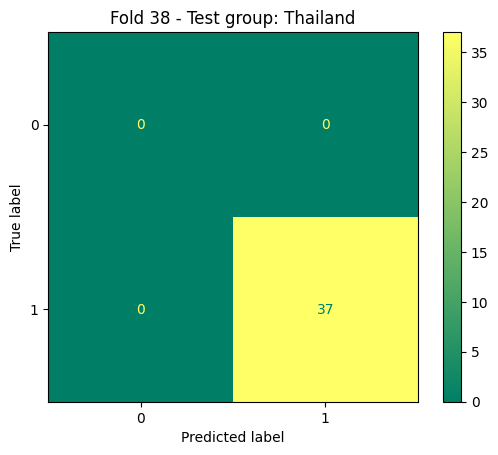


=== Fold 39: Test country = Turkey ===
Train size: 13970, Test size: 7
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0017
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06099003750332013), 'max_depth': 48, 'n_estimators': 1517, 'num_leaves': 50}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7


Confusion Matrix:
 [[7]]


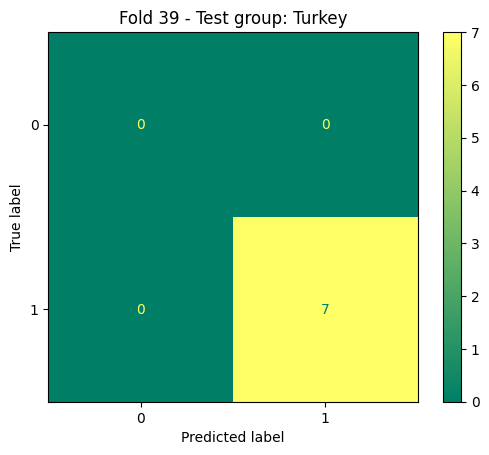


=== Fold 40: Test country = USA ===
Train size: 13745, Test size: 232
Test ROC AUC (positive class = 1): 0.5444
Test AUPRC: 0.8418
Test Brier Score: 0.2184
Test ECE: 0.1963
Test Precision (macro): 0.5128
Test Recall (macro): 0.5156
Test F1-score (macro): 0.5119

Best Parameters: {'learning_rate': np.float64(0.05236027155259325), 'max_depth': 50, 'n_estimators': 1636, 'num_leaves': 21}

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.25      0.22        40
           1       0.83      0.78      0.81       192

    accuracy                           0.69       232
   macro avg       0.51      0.52      0.51       232
weighted avg       0.72      0.69      0.70       232


Confusion Matrix:
 [[ 10  30]
 [ 42 150]]


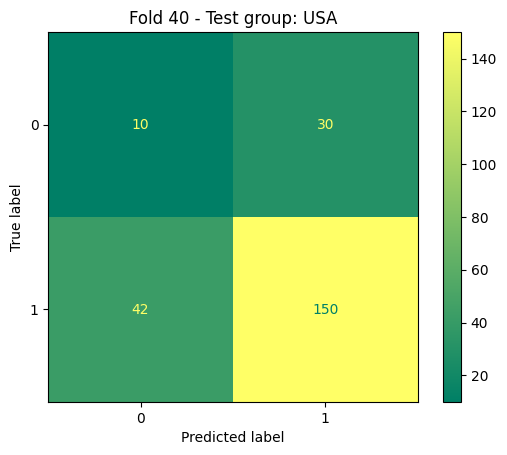


=== Fold 41: Test country = Uganda ===
Train size: 13971, Test size: 6
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0000
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06099003750332013), 'max_depth': 48, 'n_estimators': 1517, 'num_leaves': 50}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Confusion Matrix:
 [[6]]


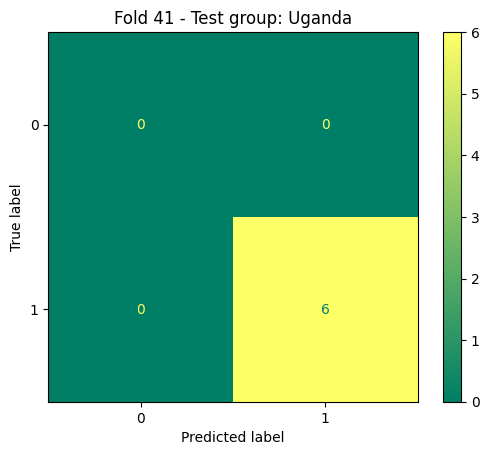


=== Fold 42: Test country = Vietnam ===
Train size: 13961, Test size: 16
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0001
Test ECE: 0.0046
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.0915810078788343), 'max_depth': 18, 'n_estimators': 1279, 'num_leaves': 43}

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        16

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16


Confusion Matrix:
 [[16]]


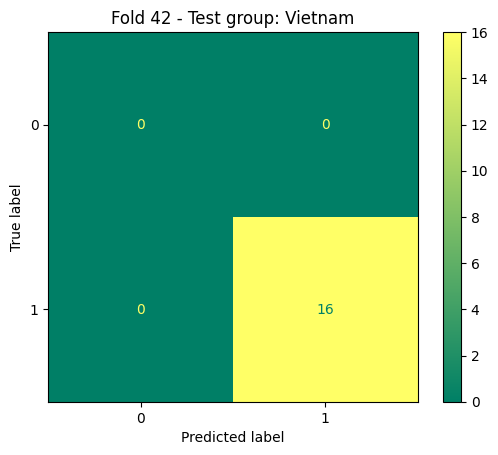


=== All Results This Run ===
    Fold       Country  Accuracy   ROC_AUC     AUPRC         Brier       ECE  \
0      1     Argentina  1.000000       NaN  1.000000  3.790248e-05  0.005577   
1      2       Austria  1.000000       NaN  1.000000  2.194098e-02  0.148125   
2      3       Belgium  1.000000       NaN  1.000000  1.244668e-04  0.010903   
3      4      Botswana  1.000000       NaN  1.000000  3.188981e-03  0.043488   
4      5        Brazil  0.942266       NaN  1.000000  4.060350e-02  0.085845   
5      6      Bulgaria  1.000000       NaN  1.000000  8.242721e-07  0.000908   
6      7         China  1.000000       NaN  1.000000  2.100005e-02  0.120434   
7      8      Colombia  1.000000       NaN  1.000000  1.830212e-04  0.012906   
8      9        France  0.302552  0.516780  0.332591  6.160596e-01  0.632369   
9     10       Germany  1.000000       NaN  1.000000  5.898820e-04  0.020683   
10    11    Guadeloupe  0.319149  0.420814  0.254163  5.713051e-01  0.589257   
11    12  

In [56]:
# ===== Imports =====
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint as sp_randint, uniform as sp_uniform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, balanced_accuracy_score, accuracy_score,
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    brier_score_loss
)
from lightgbm import LGBMClassifier

def expected_calibration_error(y_true, y_prob, n_bins=10):
    """Expected Calibration Error (ECE)."""
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = binids == i
        if np.any(bin_mask):
            avg_conf = y_prob[bin_mask].mean()
            avg_acc = y_true[bin_mask].mean()
            ece += np.abs(avg_conf - avg_acc) * bin_mask.mean()
    return ece

results = []
prf_macro_scores = {"precision": [], "recall": [], "f1": []}
logo = LeaveOneGroupOut()

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    fold_num = fold + 1
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    inner_groups = groups.iloc[train_idx]
    test_country = groups.iloc[test_idx].unique()[0]

    scaler = StandardScaler()
    X_train[['Patient age']] = scaler.fit_transform(X_train[['Patient age']])
    X_test[['Patient age']] = scaler.transform(X_test[['Patient age']])

    print(f"\n=== Fold {fold_num}: Test country = {test_country} ===")
    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")

    param_dist = {
        'n_estimators': sp_randint(500, 2100),
        'max_depth': sp_randint(10, 51),
        'learning_rate': sp_uniform(0.001, 0.099),
        'num_leaves': sp_randint(10, 51)
    }

    try:
        from sklearn.model_selection import StratifiedGroupKFold
        inner_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    except Exception:
        from sklearn.model_selection import GroupKFold
        inner_cv = GroupKFold(n_splits=5)

    scorer = make_scorer(balanced_accuracy_score)

    model = GPBoostClassifier(
        random_state=42,
        n_jobs=2,
        class_weight='balanced'
    )

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scorer,
        cv=inner_cv,
        verbose=0,
        n_jobs=2,
        random_state=42
    )

    random_search.fit(X_train, y_train, groups=inner_groups)
    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    classes = best_model.classes_
    pos_class = classes[1] if len(classes) > 1 else classes[0]
    pos_idx = np.where(classes == pos_class)[0][0]
    y_prob = best_model.predict_proba(X_test)[:, pos_idx]
    y_true_bin = (y_test == pos_class).astype(int)

    roc_auc, auprc, brier, ece = np.nan, np.nan, np.nan, np.nan

    if len(np.unique(y_true_bin)) == 2:
        roc_auc = roc_auc_score(y_true_bin, y_prob)
        print(f"Test ROC AUC (positive class = {pos_class}): {roc_auc:.4f}")
    else:
        print("ROC AUC skipped (only one class in test set)")

    auprc = average_precision_score(y_true_bin, y_prob)
    brier = brier_score_loss(y_true_bin, y_prob)
    ece = expected_calibration_error(y_true_bin.values, y_prob, n_bins=10)

    print(f"Test AUPRC: {auprc:.4f}")
    print(f"Test Brier Score: {brier:.4f}")
    print(f"Test ECE: {ece:.4f}")

    if len(y_test.unique()) > 1:
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='macro', zero_division=0
        )
        prf_macro_scores["precision"].append(precision)
        prf_macro_scores["recall"].append(recall)
        prf_macro_scores["f1"].append(f1)
        print(f"Test Precision (macro): {precision:.4f}")
        print(f"Test Recall (macro): {recall:.4f}")
        print(f"Test F1-score (macro): {f1:.4f}")
    else:
        print("Skipped Precision/Recall/F1 (only one class in test set)")

    print("\nBest Parameters:", random_search.best_params_)
    report = classification_report(y_test, y_pred, zero_division=0)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    cm_str = np.array2string(cm)
    report_str = report

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='summer', values_format='d')
    plt.title(f"Fold {fold_num} - Test group: {test_country}")
    plt.show()

    result_entry = {
        "Fold": fold_num,
        "Country": test_country,
        "Accuracy": acc,
        "ROC_AUC": roc_auc,
        "AUPRC": auprc,
        "Brier": brier,
        "ECE": ece,
        "Best_Params": random_search.best_params_,
        "Confusion_Matrix": cm_str,
        "Classification_Report": report_str
    }
    results.append(result_entry)

    with open("resultsGPBoost.txt", "a") as f:
        f.write(f"\n=== Fold {fold_num} (Country: {test_country}) ===\n")
        for key, val in result_entry.items():
            f.write(f"{key}: {val}\n")
        f.write("\n")

results_df = pd.DataFrame(results)
print("\n=== All Results This Run ===")
print(results_df)

with open("resultsGPBoost.txt", "a") as f:
    f.write("\n=== Summary (This Run) ===\n")
    f.write(results_df.to_string(index=False))
    f.write("\n")
    f.write(f"\nMean Accuracy: {results_df['Accuracy'].mean():.4f}\n")
    if results_df["ROC_AUC"].notna().any():
        f.write(f"Mean ROC AUC: {results_df['ROC_AUC'].dropna().mean():.4f}\n")
    if results_df["AUPRC"].notna().any():
        f.write(f"Mean AUPRC: {results_df['AUPRC'].dropna().mean():.4f}\n")
    if results_df["Brier"].notna().any():
        f.write(f"Mean Brier Score: {results_df['Brier'].dropna().mean():.4f}\n")
    if results_df["ECE"].notna().any():
        f.write(f"Mean ECE: {results_df['ECE'].dropna().mean():.4f}\n")
